IMPORTATION DES LIBRAIRIES

In [58]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import skew, kurtosis, spearmanr, pearsonr
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 120)


IMPORTATION DU FICHIER EXCEL

In [59]:
file_path = "donnees_immobilieres_extended.xlsx"

#Chargement de DataFrame : nous vérifions que la base de données ait bien été importée.
try : 
    df = pd.read_excel(file_path)
    print(f"Le fichier '{file_path}' a été chargé avec succès")
except FileNotFoundError :
    print(f"Le fichier '{file_path}' est introuvable. Vérifier le dossier")
    df = pd.DataFrame()

Le fichier 'donnees_immobilieres_extended.xlsx' a été chargé avec succès


VERIFICATION DE LA COMPOSITION DES DONNEES

In [60]:
print("Shape:", df.shape)
display(df.head(5))
display(df.tail(3))
display(df.dtypes)

Shape: (150, 12)


,ID,Surface_m2,Chambres,Annee_construction,Distance_centre_km,Etage,Ascenseur,Annee_vente,Qualite_ecole,Revenu_median_quartier,Distance_universite,Prix_milliers_euros
0,1,139.87,3,1982,21.33,2,1,2023,1.1,47.5,11.9,1961.68
1,2,114.47,4,1991,2.90,5,1,2022,4.7,44.2,11.9,2303.67
2,3,145.91,2,2005,3.00,3,1,2017,3.2,53.8,10.7,2224.12
3,4,180.92,4,1995,29.61,3,1,2022,6.1,68.3,11.1,2425.63
4,5,110.63,3,2016,11.54,0,0,2021,9.0,81.9,10.8,2323.34


,ID,Surface_m2,Chambres,Annee_construction,Distance_centre_km,Etage,Ascenseur,Annee_vente,Qualite_ecole,Revenu_median_quartier,Distance_universite,Prix_milliers_euros
147,148,67.18,1,2021,7.58,4,0,2019,5.4,71.6,8.7,1902.30
148,149,140.88,3,1988,2.74,3,0,2020,5.0,54.4,9.5,2252.99
149,150,131.88,2,2006,4.30,4,0,2020,4.3,67.5,11.4,2289.51


ID                          int64
Surface_m2                float64
Chambres                    int64
Annee_construction          int64
Distance_centre_km        float64
Etage                       int64
Ascenseur                   int64
Annee_vente                 int64
Qualite_ecole             float64
Revenu_median_quartier    float64
Distance_universite       float64
Prix_milliers_euros       float64
dtype: object

ANALYSE DES DONNEES

In [61]:
#Vérifie les doublons
dup_count = df.duplicated().sum()
print("Duplicated rows:", dup_count)

#Vérifie les valeurs manquantes
na = df.isna().sum().sort_values(ascending=False)
display(na[na > 0])

#Vérifications de domaine (règles métier minimales)
checks = {}
checks["Surface_m2 <= 0"] = int((df["Surface_m2"] <= 0).sum())
checks["Chambres <= 0"] = int((df["Chambres"] <= 0).sum())
checks["Distance_centre_km < 0"] = int((df["Distance_centre_km"] < 0).sum())
checks["Distance_universite < 0"] = int((df["Distance_universite"] < 0).sum())
checks["Ascenseur not in {0,1}"] = int((~df["Ascenseur"].isin([0,1])).sum())

#Années plausibles
checks["Annee_construction < 1800"] = int((df["Annee_construction"] < 1800).sum())
checks["Annee_vente < 1990"] = int((df["Annee_vente"] < 1990).sum())
checks["Annee_construction > Annee_vente"] = int((df["Annee_construction"] > df["Annee_vente"]).sum())

display(pd.Series(checks, name="count"))

Duplicated rows: 0


Series([], dtype: int64)

Surface_m2 <= 0                     0
Chambres <= 0                       0
Distance_centre_km < 0              0
Distance_universite < 0             0
Ascenseur not in {0,1}              0
Annee_construction < 1800           0
Annee_vente < 1990                  0
Annee_construction > Annee_vente    5
Name: count, dtype: int64

DEFINITION DES VARIABLES

In [62]:
ID = "ID"
TARGET = "Prix_milliers_euros"
binary = ["Ascenseur"]
discrete = ["Chambres", "Etage", "Qualite_ecole"]  # Qualite_ecole = score (ordonné), discutable mais OK ici
continuous = ["Surface_m2", "Distance_centre_km", "Revenu_median_quartier", "Distance_universite"]
time = ["Annee_construction", "Annee_vente"]  # variables temporelles (numériques mais interprétation spécifique)
features = binary + discrete + continuous + time
assert set([ID, TARGET] + features) == set(df.columns), "Mismatch colonnes - vérifie les listes"

## 1. Statistiques Descriptives et Analyse Préliminaire

### 1.1. Statistiques descriptives

In [63]:
#Table standard + quartiles
desc = df[features + [TARGET]].describe(percentiles=[0.25, 0.5, 0.75]).T
desc = desc.rename(columns={
    "count":"n", "mean":"mean", "50%":"median", "std":"std",
    "min":"min", "25%":"Q1", "75%":"Q3", "max":"max"
})
desc = desc[["n","mean","median","std","min","Q1","Q3","max"]]
display(desc.round(3))

,n,mean,median,std,min,Q1,Q3,max
Ascenseur,150.0,0.460,0.000,0.500,0.00,0.000,1.000,1.00
Chambres,150.0,2.887,3.000,1.078,1.00,2.000,4.000,5.00
Etage,150.0,2.580,2.500,1.762,0.00,1.000,4.000,5.00
Qualite_ecole,150.0,5.469,5.600,1.868,1.00,4.125,7.000,10.00
Surface_m2,150.0,116.707,117.845,37.694,15.21,93.240,139.638,218.53
Distance_centre_km,150.0,16.500,16.865,9.017,0.83,9.105,24.698,29.99
Revenu_median_quartier,150.0,63.668,63.450,9.295,42.90,57.500,70.475,83.90
Distance_universite,150.0,8.064,8.300,3.747,1.00,5.300,10.875,17.10
Annee_construction,150.0,2001.827,2002.500,11.705,1980.00,1991.000,2012.000,2022.00
Annee_vente,150.0,2019.840,2020.000,2.288,2015.00,2018.000,2022.000,2023.00


In [64]:
#Indicateurs “robustes” + taux d’outliers IQR
def outlier_rate_iqr(s):
    s = s.dropna()
    q1, q3 = s.quantile([0.25, 0.75])
    iqr = q3 - q1
    lo, hi = q1 - 1.5*iqr, q3 + 1.5*iqr
    return float(((s < lo) | (s > hi)).mean())

def mad(s):
    s = s.dropna()
    med = np.median(s)
    return float(np.median(np.abs(s - med)))

eda = pd.DataFrame(index=features + [TARGET])
eda["skew"] = df[features + [TARGET]].apply(lambda s: skew(s.dropna()))
eda["kurtosis_excess"] = df[features + [TARGET]].apply(lambda s: kurtosis(s.dropna(), fisher=True))
eda["MAD"] = df[features + [TARGET]].apply(mad)
eda["outlier_rate_IQR"] = df[features + [TARGET]].apply(outlier_rate_iqr)

display(eda.round(3).sort_values("outlier_rate_IQR", ascending=False))


,skew,kurtosis_excess,MAD,outlier_rate_IQR
Surface_m2,0.047,-0.142,22.860,0.013
Ascenseur,0.161,-1.974,0.000,0.000
Chambres,0.097,-0.707,1.000,0.000
Etage,-0.011,-1.332,1.500,0.000
Qualite_ecole,-0.144,-0.520,1.400,0.000
Distance_centre_km,-0.141,-1.192,7.915,0.000
Revenu_median_quartier,0.051,-0.601,6.900,0.000
Distance_universite,-0.115,-0.648,2.800,0.000
Annee_construction,-0.082,-1.167,10.500,0.000
Annee_vente,-0.319,-1.012,2.000,0.000


In [65]:
#skewness & kurtosis du prix
y = df[TARGET].dropna()
print("Skewness(Prix):", skew(y))
print("Excess kurtosis(Prix):", kurtosis(y, fisher=True))


Skewness(Prix): 0.15466383953663695
Excess kurtosis(Prix): -0.4929776130918855


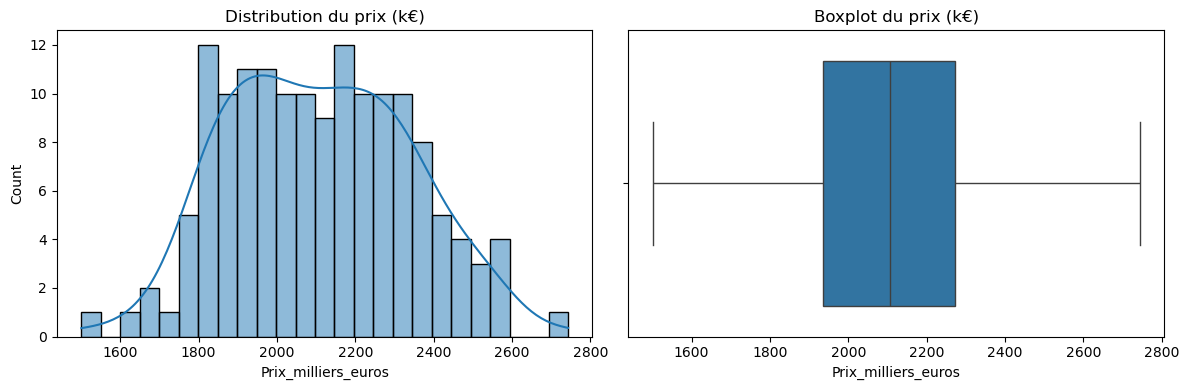

In [66]:
#Histogramme + boxplot du prix
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

sns.histplot(df[TARGET], bins=25, kde=True, ax=ax[0])
ax[0].set_title("Distribution du prix (k€)")

sns.boxplot(x=df[TARGET], ax=ax[1])
ax[1].set_title("Boxplot du prix (k€)")

plt.tight_layout()
plt.show()


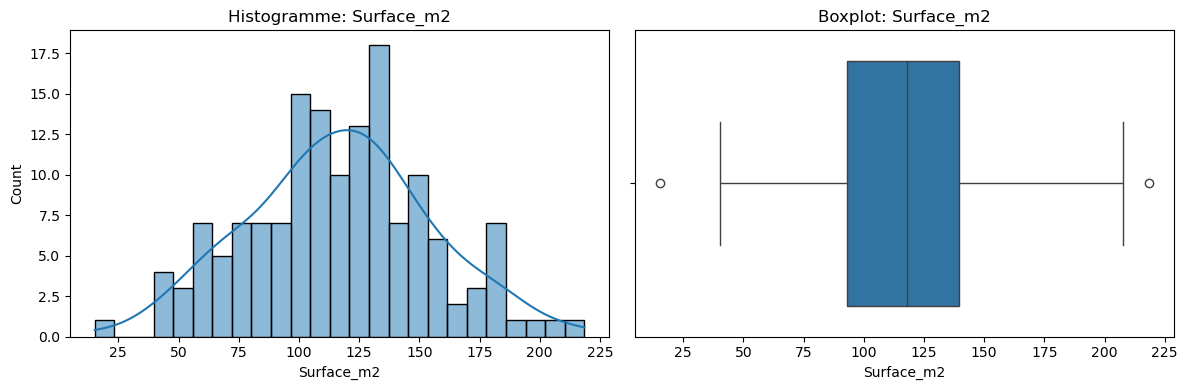

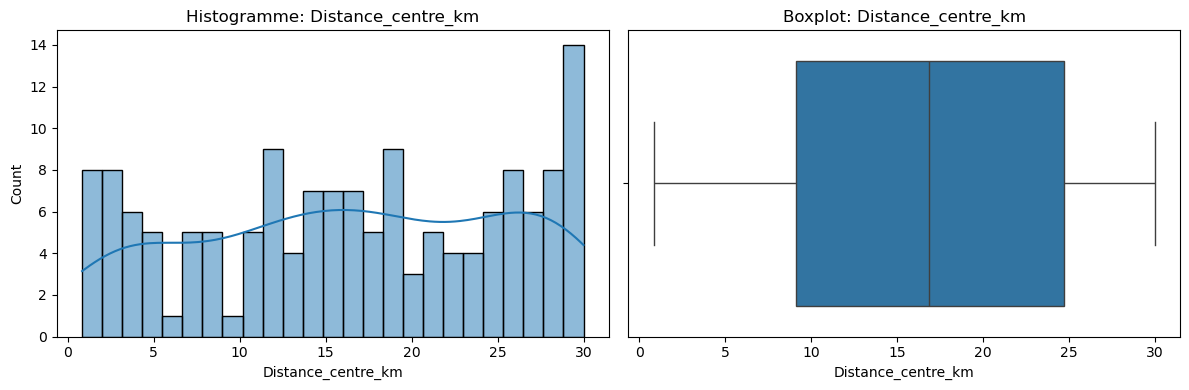

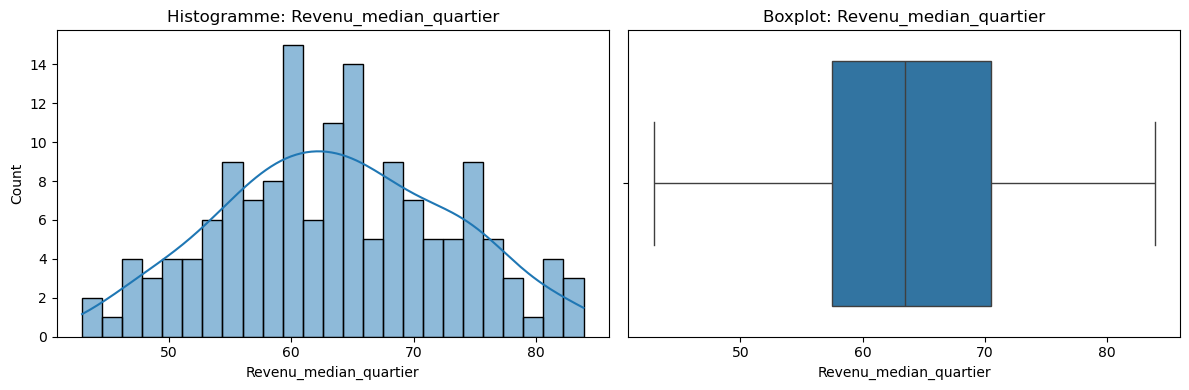

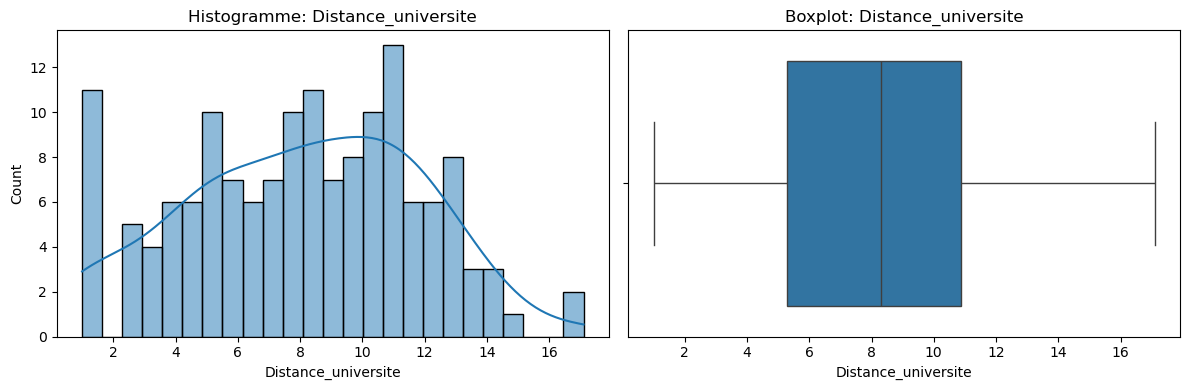

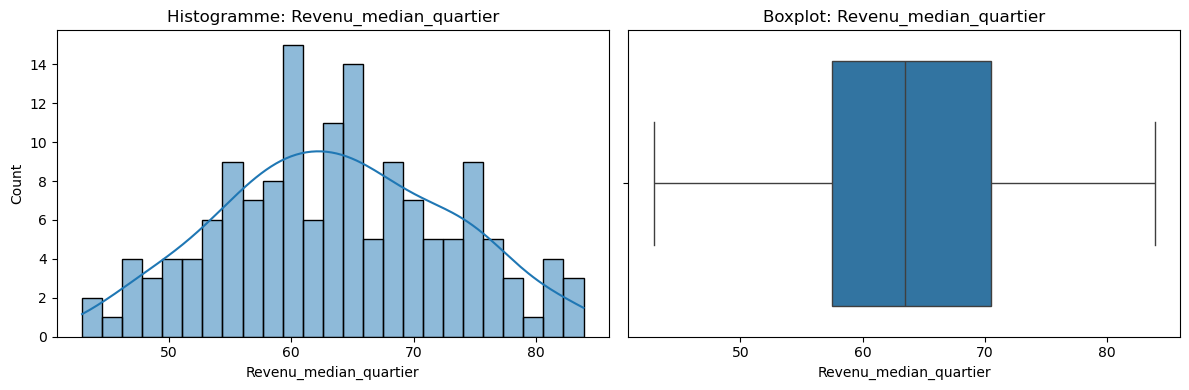

In [67]:
#Histogrammes + boxplots des variables continues
for v in continuous + ["Revenu_median_quartier"]:
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    sns.histplot(df[v], bins=25, kde=True, ax=ax[0])
    ax[0].set_title(f"Histogramme: {v}")
    sns.boxplot(x=df[v], ax=ax[1])
    ax[1].set_title(f"Boxplot: {v}")
    plt.tight_layout()
    plt.show()


Skew prix: 0.15466383953663695
Skew log1p(prix): -0.09429149190210759


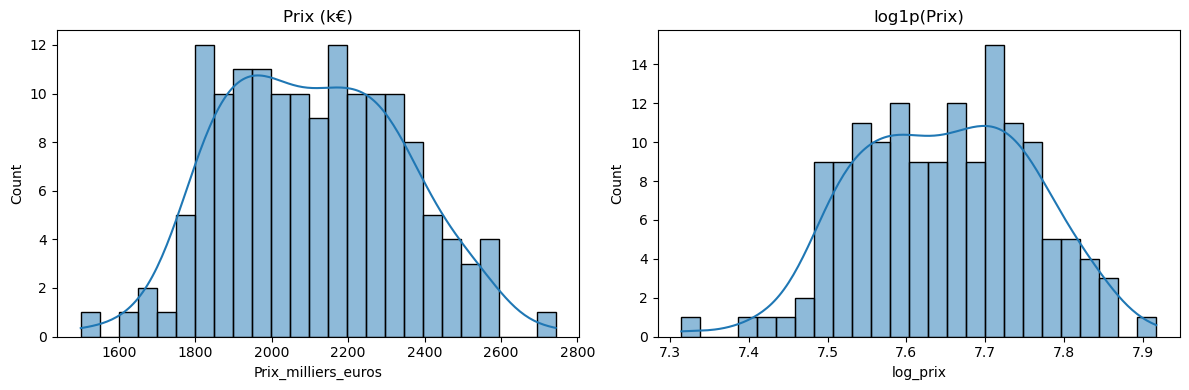

In [68]:
#Transformation log
df["log_prix"] = np.log1p(df[TARGET])

print("Skew prix:", skew(df[TARGET].dropna()))
print("Skew log1p(prix):", skew(df["log_prix"].dropna()))

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
sns.histplot(df[TARGET], bins=25, kde=True, ax=ax[0]); ax[0].set_title("Prix (k€)")
sns.histplot(df["log_prix"], bins=25, kde=True, ax=ax[1]); ax[1].set_title("log1p(Prix)")
plt.tight_layout()
plt.show()


In [69]:
candidates = ["Surface_m2", "Revenu_median_quartier", "Distance_centre_km", "Distance_universite"]

for v in candidates:
    if (df[v] <= 0).any():
        continue  # log impossible si <=0
    lv = "log_" + v
    df[lv] = np.log(df[v])

    print(v, "skew:", skew(df[v].dropna()), "|", lv, "skew:", skew(df[lv].dropna()))


Surface_m2 skew: 0.047238299963779366 | log_Surface_m2 skew: -1.3907353600321453
Revenu_median_quartier skew: 0.051392557698256534 | log_Revenu_median_quartier skew: -0.2655870257464887
Distance_centre_km skew: -0.14051920604139156 | log_Distance_centre_km skew: -1.328729235221249
Distance_universite skew: -0.11525000887549569 | log_Distance_universite skew: -1.495221875907431


1.2. Corrélations

In [70]:
#Corrélation au prix
corr_pearson = df[features + [TARGET]].corr(method="pearson")[TARGET].drop(TARGET).sort_values(key=np.abs, ascending=False)
corr_spearman = df[features + [TARGET]].corr(method="spearman")[TARGET].drop(TARGET).sort_values(key=np.abs, ascending=False)

corr_compare = pd.DataFrame({"pearson": corr_pearson, "spearman": corr_spearman})
display(corr_compare)


,pearson,spearman
Annee_construction,0.068358,0.066299
Annee_vente,0.236992,0.259913
Ascenseur,0.038303,0.059775
Chambres,0.614825,0.589006
Distance_centre_km,-0.306648,-0.310988
Distance_universite,-0.124521,-0.142059
Etage,0.128403,0.120814
Qualite_ecole,0.253632,0.255205
Revenu_median_quartier,0.205779,0.198608
Surface_m2,0.826731,0.809089


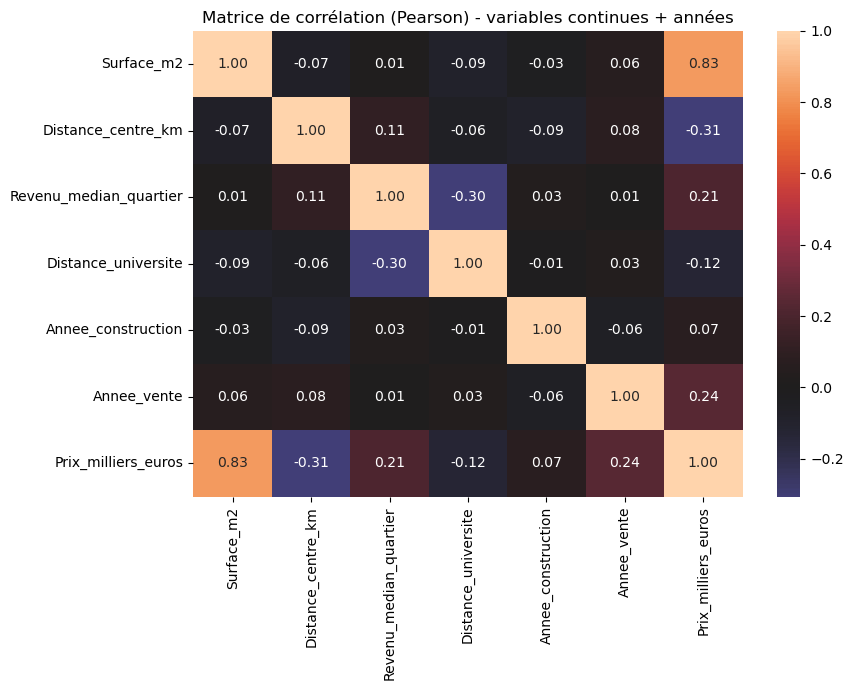

In [71]:
#Heatmap
corr_vars = continuous + time + [TARGET]
corr = df[corr_vars].corr(method="pearson")

plt.figure(figsize=(9, 7))
sns.heatmap(corr, annot=True, fmt=".2f", center=0)
plt.title("Matrice de corrélation (Pearson) - variables continues + années")
plt.tight_layout()
plt.show()


In [72]:
#Paires fortement corrélées
threshold = 0.75
C = df[corr_vars].corr()

pairs = (C.where(np.triu(np.ones(C.shape), k=1).astype(bool))
           .stack()
           .reset_index())
pairs.columns = ["var1","var2","corr"]

strong_pairs = pairs.loc[pairs["corr"].abs() >= threshold].sort_values("corr", ascending=False)
display(strong_pairs)


,var1,var2,corr
5,Surface_m2,Prix_milliers_euros,0.826731


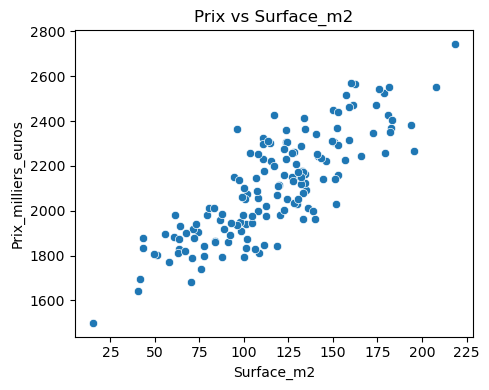

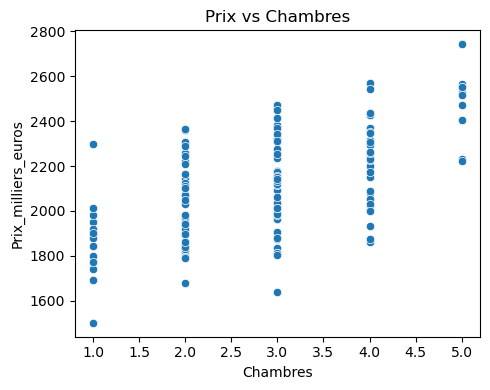

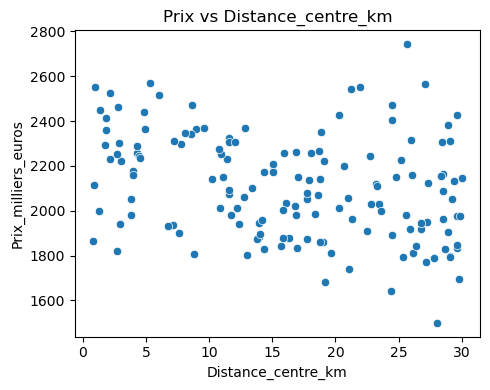

In [73]:
#Scatterplots des top relations
top3 = corr_pearson.head(3).index.tolist()
for v in top3:
    plt.figure(figsize=(5,4))
    sns.scatterplot(x=df[v], y=df[TARGET])
    plt.title(f"Prix vs {v}")
    plt.tight_layout()
    plt.show()

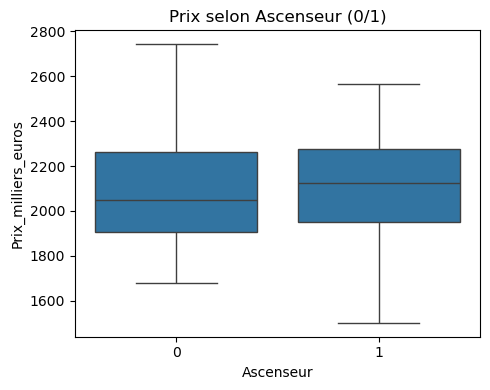

,count,mean,median,std
Ascenseur,,,,
0,81,2099.80,2050.61,232.46
1,69,2117.41,2125.50,228.23


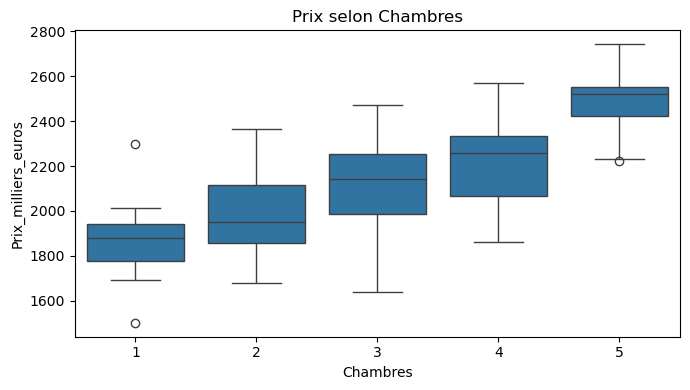

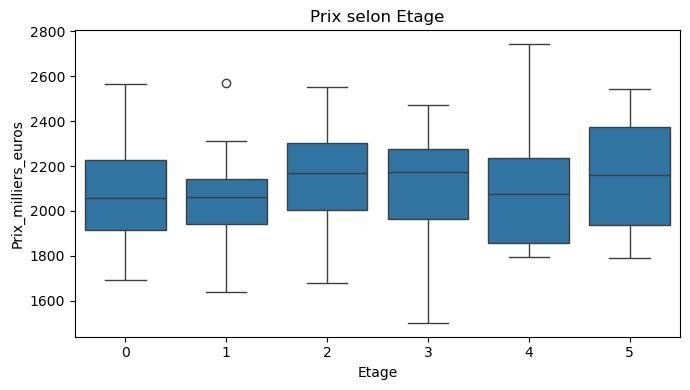

In [74]:
#Variables binaires/discrètes vs prix
#Ascenseur
plt.figure(figsize=(5,4))
sns.boxplot(x=df["Ascenseur"], y=df[TARGET])
plt.title("Prix selon Ascenseur (0/1)")
plt.tight_layout()
plt.show()

display(df.groupby("Ascenseur")[TARGET].agg(["count","mean","median","std"]).round(2))

for v in ["Chambres", "Etage"]:
    plt.figure(figsize=(7,4))
    sns.boxplot(x=df[v], y=df[TARGET])
    plt.title(f"Prix selon {v}")
    plt.tight_layout()
    plt.show()


## 2. Le modèle linéaire : estimation et interprétation

### 2.1. Modèle de régression linéaire simple
$$Prix_i = \beta_0 + \beta_1 \times Surface_i + u_i$$

In [75]:
X = df[["Surface_m2"]]
y = df[TARGET]

X = sm.add_constant(X)
model_simple = sm.OLS(y, X).fit()
model_simple.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     Prix_milliers_euros   R-squared:                       0.683
Model:                             OLS   Adj. R-squared:                  0.681
Method:                  Least Squares   F-statistic:                     319.6
Date:                 Sun, 28 Dec 2025   Prob (F-statistic):           8.45e-39
Time:                         16:24:15   Log-Likelihood:                -941.72
No. Observations:                  150   AIC:                             1887.
Df Residuals:                      148   BIC:                             1893.
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1519.3743     34.584     43.932      0.000    1451.031    1587.717
Surface_m2     5.0428      0.282     17.877      0.000       4.485       5.600
==============================================================================
Omnibus:                        1.117   Durbin-Watson:                   2.136
Prob(Omnibus):                  0.572   Jarque-Bera (JB):                1.173
Skew:                           0.131   Prob(JB):                        0.556
Kurtosis:                       2.655   Cond. No.                         400.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [76]:
#Résultats (tableau 3) : coefficients, écarts-types, t-stats, p-values et R²

table3 = pd.DataFrame({
    "coef": model_simple.params,
    "std_err": model_simple.bse,
    "t": model_simple.tvalues,
    "p_value": model_simple.pvalues
}).round(4)

table3


,coef,std_err,t,p_value
const,1519.3743,34.5845,43.9323,0.0
Surface_m2,5.0428,0.2821,17.8771,0.0


In [77]:
#Qualité d'ajustement (modèle simple)
print("R² :", round(model_simple.rsquared, 4))
print("R² ajusté :", round(model_simple.rsquared_adj, 4))
print("F-statistic :", round(model_simple.fvalue, 4))
print("p-value (F-test) :", model_simple.f_pvalue)

R² : 0.6835
R² ajusté : 0.6813
F-statistic : 319.5914
p-value (F-test) : 8.445518499008712e-39


### 2.2 Modèle de régression linéaire multiple

$$Prix_i = \beta_0 + \beta_1 Surface_i + \beta_2 Chambres_i + \beta_3 Annee\_construction_i + \beta_4 Distance\_centre_i + \beta_5 Etage_i + \beta_6 Ascenseur_i + u_i$$

In [78]:
X_cols = ["Surface_m2", "Chambres", "Annee_construction", "Distance_centre_km", "Etage", "Ascenseur"]
data_mult = df[X_cols + [TARGET]].dropna().copy()

y = data_mult[TARGET]
X = sm.add_constant(data_mult[X_cols])

model_mult = sm.OLS(y, X).fit()
model_mult.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     Prix_milliers_euros   R-squared:                       0.789
Model:                             OLS   Adj. R-squared:                  0.780
Method:                  Least Squares   F-statistic:                     88.94
Date:                 Sun, 28 Dec 2025   Prob (F-statistic):           9.10e-46
Time:                         16:24:15   Log-Likelihood:                -911.43
No. Observations:                  150   AIC:                             1837.
Df Residuals:                      143   BIC:                             1858.
Df Model:                            6                                         
Covariance Type:             nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const              -1679.4908   1535.673     -1.094      0.276   -4715.044    1356.062
Surface_m2             4.3879      0.292     15.005      0.000       3.810       4.966
Chambres              33.9205     10.228      3.316      0.001      13.703      54.138
Annee_construction     1.6093      0.765      2.103      0.037       0.097       3.122
Distance_centre_km    -6.1446      0.992     -6.194      0.000      -8.106      -4.184
Etage                 12.2540      5.049      2.427      0.016       2.274      22.234
Ascenseur             55.5141     17.920      3.098      0.002      20.092      90.937
==============================================================================
Omnibus:                        0.955   Durbin-Watson:                   2.121
Prob(Omnibus):                  0.620   Jarque-Bera (JB):                1.031
Skew:                           0.112   Prob(JB):                        0.597
Kurtosis:                       2.662   Cond. No.                     3.50e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.5e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [79]:
#Résultats
table4 = pd.DataFrame({
    "coef": model_mult.params,
    "std_err": model_mult.bse,
    "t": model_mult.tvalues,
    "p_value": model_mult.pvalues
}).round(4)

table4

,coef,std_err,t,p_value
const,-1679.4908,1535.6730,-1.0937,0.2759
Surface_m2,4.3879,0.2924,15.0047,0.0000
Chambres,33.9205,10.2279,3.3165,0.0012
Annee_construction,1.6093,0.7653,2.1030,0.0372
Distance_centre_km,-6.1446,0.9921,-6.1936,0.0000
Etage,12.2540,5.0489,2.4271,0.0165
Ascenseur,55.5141,17.9201,3.0979,0.0023


In [80]:
#Qualité d'ajustement : R² vs R² ajusté
print("R2:", round(model_mult.rsquared, 4))
print("R2 ajusté:", round(model_mult.rsquared_adj, 4))
print("F-stat:", round(model_mult.fvalue, 4))
print( "p(F):", model_mult.f_pvalue)

R2: 0.7887
R2 ajusté: 0.7798
F-stat: 88.9375
p(F): 9.103739165386944e-46


### 2.3 Transformation logarithmique (semi-log et log-log)

#### 2.3.1 Création des variables transformées et vérification des conditions 

In [81]:
#Préparation des variables (log)
# On travaille sur le même sous-échantillon que le modèle multiple pour comparer proprement.
df_23 = data_mult.copy()

# Vérification (logs nécessitent des valeurs strictement positives)
assert (df_23[TARGET] > 0).all(), "Prix contient des valeurs <= 0 : log impossible."
assert (df_23["Surface_m2"] > 0).all(), "Surface contient des valeurs <= 0 : log impossible."

# Distance peut être 0 théoriquement : on protège avec log1p si nécessaire
use_log1p_distance = (df_23["Distance_centre_km"] <= 0).any()

df_23["log_prix"] = np.log(df_23[TARGET])
df_23["log_surface"] = np.log(df_23["Surface_m2"])

if use_log1p_distance:
    df_23["log_distance"] = np.log1p(df_23["Distance_centre_km"])
else:
    df_23["log_distance"] = np.log(df_23["Distance_centre_km"])

# Etage peut être 0 (rez-de-chaussée) -> log1p
df_23["log1p_etage"] = np.log1p(df_23["Etage"])

df_23[["log_prix","log_surface","log_distance","log1p_etage"]].head()


,log_prix,log_surface,log_distance,log1p_etage
0,7.581557,4.940713,3.060115,1.098612
1,7.742259,4.740313,1.064711,1.791759
2,7.707117,4.982990,1.098612,1.386294
3,7.793847,5.198055,3.388112,1.386294
4,7.750761,4.706191,2.445819,0.000000


#### 2.3.2 Modèle semi-log
$$\log(Prix_i)=\beta_0 + \beta_1 Surface_i + \beta_2 Chambres_i + \beta_3 Annee\_construction_i + \beta_4 Distance\_centre_i + \beta_5 Etage_i + \beta_6 Ascenseur_i + u_i$$

In [82]:
X_semi = sm.add_constant(df_23[X_cols])
y_semi = df_23["log_prix"]

model_semi = sm.OLS(y_semi, X_semi).fit()
model_semi.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               log_prix   R-squared:                       0.792
Model:                            OLS   Adj. R-squared:                  0.783
Method:                 Least Squares   F-statistic:                     90.56
Date:                Sun, 28 Dec 2025   Prob (F-statistic):           3.31e-46
Time:                        16:24:15   Log-Likelihood:                 237.10
No. Observations:                 150   AIC:                            -460.2
Df Residuals:                     143   BIC:                            -439.1
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  5.8413      0.726      8.045      0.000       4.406       7.276
Surface_m2             0.0021      0.000     15.259      0.000       0.002       0.002
Chambres               0.0152      0.005      3.153      0.002       0.006       0.025
Annee_construction     0.0008      0.000      2.126      0.035     5.4e-05       0.001
Distance_centre_km    -0.0030      0.000     -6.417      0.000      -0.004      -0.002
Etage                  0.0053      0.002      2.231      0.027       0.001       0.010
Ascenseur              0.0265      0.008      3.128      0.002       0.010       0.043
==============================================================================
Omnibus:                        1.577   Durbin-Watson:                   2.055
Prob(Omnibus):                  0.454   Jarque-Bera (JB):                1.311
Skew:                           0.006   Prob(JB):                        0.519
Kurtosis:                       2.542   Cond. No.                     3.50e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.5e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### 2.3.3 Modèle log-log (mixte)
On log-transforme les variables continues (Surface, Distance) et on utilise log(Etage+1).

$$\log(Prix_i)=\beta_0 + \beta_1 \log(Surface_i) + \beta_2 Chambres_i + \beta_3 Annee\_construction_i + \beta_4 \log(Distance\_centre_i) + \beta_5 \log(Etage_i+1) + \beta_6 Ascenseur_i + u_i$$

In [83]:
X_loglog_cols = ["log_surface", "Chambres", "Annee_construction", "log_distance", "log1p_etage", "Ascenseur"]
X_loglog = sm.add_constant(df_23[X_loglog_cols])
y_loglog = df_23["log_prix"]

model_loglog = sm.OLS(y_loglog, X_loglog).fit()
model_loglog.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               log_prix   R-squared:                       0.753
Model:                            OLS   Adj. R-squared:                  0.743
Method:                 Least Squares   F-statistic:                     72.72
Date:                Sun, 28 Dec 2025   Prob (F-statistic):           5.51e-41
Time:                        16:24:15   Log-Likelihood:                 224.38
No. Observations:                 150   AIC:                            -434.8
Df Residuals:                     143   BIC:                            -413.7
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  5.6928      0.788      7.221      0.000       4.135       7.251
log_surface            0.1892      0.014     13.210      0.000       0.161       0.218
Chambres               0.0228      0.005      4.520      0.000       0.013       0.033
Annee_construction     0.0005      0.000      1.321      0.189      -0.000       0.001
log_distance          -0.0255      0.005     -4.766      0.000      -0.036      -0.015
log1p_etage            0.0153      0.007      2.046      0.043       0.001       0.030
Ascenseur              0.0268      0.009      2.901      0.004       0.009       0.045
==============================================================================
Omnibus:                        0.385   Durbin-Watson:                   2.142
Prob(Omnibus):                  0.825   Jarque-Bera (JB):                0.539
Skew:                          -0.077   Prob(JB):                        0.764
Kurtosis:                       2.750   Cond. No.                     3.48e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.48e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### 2.3.4 Comparaison des trois modèles

In [84]:
comparison_23 = pd.DataFrame({
    "Modèle": ["Niveau (2.2)", "Semi-log", "Log-log (mix)"],
    "Variable dépendante": ["Prix", "log(Prix)", "log(Prix)"],
    "R² ajusté": [model_mult.rsquared_adj, model_semi.rsquared_adj, model_loglog.rsquared_adj],
    "AIC": [model_mult.aic, model_semi.aic, model_loglog.aic],
    "BIC": [model_mult.bic, model_semi.bic, model_loglog.bic],
    "N": [int(model_mult.nobs), int(model_semi.nobs), int(model_loglog.nobs)],
}).round(4)

comparison_23

,Modèle,Variable dépendante,R² ajusté,AIC,BIC,N
0,Niveau (2.2),Prix,0.7798,1836.8581,1857.9325,150
1,Semi-log,log(Prix),0.7829,-460.1943,-439.1198,150
2,Log-log (mix),log(Prix),0.7428,-434.7680,-413.6935,150


#### 2.3.5 Interprétation des coefficients en log
- **Semi-log** : un coefficient β sur X (en niveau) s'interprète approximativement comme une variation de **100×β %** du prix.
- **Log-log** : un coefficient β sur log(X) est une **élasticité** : +1% de X → β% sur le prix.

In [85]:
beta_surface_semi = model_semi.params["Surface_m2"]
pct_exact = 100*(np.exp(beta_surface_semi) - 1)

print("Semi-log : +1 m² (Surface) -> variation exacte du prix (en %) ≈", round(pct_exact, 3))

print("Log-log : élasticité prix/surface =", round(model_loglog.params["log_surface"], 4))

Semi-log : +1 m² (Surface) -> variation exacte du prix (en %) ≈ 0.211
Log-log : élasticité prix/surface = 0.1892


## 3. Diagnostics du Modèle

In [86]:
#pré-diagnostic multicolinéarité
X_vif = df[
    ["Surface_m2", "Distance_centre_km", "Revenu_median_quartier", "Distance_universite",
     "Chambres", "Qualite_ecole", "Annee_vente", "Annee_construction"]
].dropna()

X_vif = sm.add_constant(X_vif)

vif = pd.DataFrame({
    "variable": X_vif.columns,
    "VIF": [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
}).sort_values("VIF", ascending=False)

vif


,variable,VIF
0,const,840442.999003
6,Qualite_ecole,1.788673
3,Revenu_median_quartier,1.588558
5,Chambres,1.567681
1,Surface_m2,1.557348
4,Distance_universite,1.270722
2,Distance_centre_km,1.042918
8,Annee_construction,1.019259
7,Annee_vente,1.016188


In [87]:
desc.to_csv("Tableau2_stats_descriptives.csv")
table3.to_csv("Tableau3_modele_simple.csv")
table4.to_csv("Tableau4_modele_multiple.csv")
vif.to_csv("Diagnostic_VIF.csv", index=False)

## 4. Tests et inférences

In [88]:
#On reconstitue le modèle multiple sur lequelle nous allons faire des tests
vars_x = [
    "Surface_m2","Chambres","Annee_construction","Distance_centre_km",
    "Etage","Ascenseur","Annee_vente","Qualite_ecole","Revenu_median_quartier"
]

df_reg = df.dropna(subset=[TARGET] + vars_x).copy()

X = sm.add_constant(df_reg[vars_x])
y = df_reg[TARGET]

model_mult = sm.OLS(y, X).fit()
model_mult.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     Prix_milliers_euros   R-squared:                       0.893
Model:                             OLS   Adj. R-squared:                  0.886
Method:                  Least Squares   F-statistic:                     129.9
Date:                 Sun, 28 Dec 2025   Prob (F-statistic):           2.02e-63
Time:                         16:24:15   Log-Likelihood:                -860.33
No. Observations:                  150   AIC:                             1741.
Df Residuals:                      140   BIC:                             1771.
Df Model:                            9                                         
Covariance Type:             nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                  -4.509e+04   5864.560     -7.689      0.000   -5.67e+04   -3.35e+04
Surface_m2                 4.2294      0.211     20.050      0.000       3.812       4.646
Chambres                  35.1511      7.367      4.771      0.000      20.585      49.717
Annee_construction         1.6996      0.552      3.080      0.002       0.609       2.791
Distance_centre_km        -7.0565      0.720     -9.796      0.000      -8.481      -5.632
Etage                      9.1322      3.666      2.491      0.014       1.884      16.380
Ascenseur                 54.9263     12.971      4.235      0.000      29.282      80.570
Annee_vente               21.2810      2.825      7.532      0.000      15.695      26.867
Qualite_ecole             19.9149      4.276      4.658      0.000      11.462      28.368
Revenu_median_quartier     2.7593      0.865      3.192      0.002       1.050       4.468
==============================================================================
Omnibus:                        8.741   Durbin-Watson:                   2.282
Prob(Omnibus):                  0.013   Jarque-Bera (JB):               15.517
Skew:                           0.199   Prob(JB):                     0.000427
Kurtosis:                       4.524   Cond. No.                     2.64e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.64e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### 4.1.1 Test : la distance au centre a-t-elle un effet négatif sur le prix ?

**Étape 1 — Formulation des hypothèses**

On souhaite tester si la distance au centre-ville a un effet négatif sur le prix des logements.

Hypothèse nulle :  
H0 : β_Distance_centre_km ≥ 0  
(la distance au centre n’a pas d’effet négatif sur le prix)

Hypothèse alternative :  
H1 : β_Distance_centre_km < 0  
(la distance au centre a un effet négatif sur le prix)

Ce test est un test unilatéral à gauche.



In [89]:
t = model_mult.tvalues["Distance_centre_km"]
p_two = model_mult.pvalues["Distance_centre_km"]

# p-value unilatérale pour H1: beta < 0
p_one = p_two/2 if t < 0 else 1 - p_two/2

beta = model_mult.params["Distance_centre_km"]

print("beta_distance =", beta)
print("t-stat =", t)
print("p-value (one-sided, H1: beta < 0) =", p_one)


beta_distance = -7.056502851202576
t-stat = -9.795534946840657
p-value (one-sided, H1: beta < 0) = 7.068721187320534e-18


# Partie 6

## 6.1 — Sources d’endogénéité et cas de `Qualite_ecole`

**Endogénéité** : une variable explicative est endogène si elle est corrélée avec l’erreur du modèle, ce qui rend l’estimation MCO biaisée.

Sources classiques :
1) **Variable omise** (ex : qualité globale du quartier non observée) corrélée à la fois au prix et à une variable explicative.
2) **Simultanéité / causalité inverse** (prix ↔ certaines caractéristiques).
3) **Erreur de mesure**.

Ici, `Qualite_ecole` est potentiellement endogène car elle peut refléter des caractéristiques non observées du quartier (attractivité, sécurité, standing) qui influencent aussi le prix. Le coefficient MCO de `Qualite_ecole` peut donc être biaisé.

In [90]:
TARGET = "Prix_milliers_euros"
endo   = "Qualite_ecole"          # variable suspecte endogène
instr  = "Distance_universite"    # instrument proposé

# Contrôles exogènes (mêmes contrôles partout)
controls = [
    "Surface_m2",
    "Distance_centre_km",
    "Revenu_median_quartier",
    "Chambres",
    "Ascenseur",
    "Annee_vente",
    "Annee_construction"
]

df[[TARGET, endo, instr] + controls].head()

,Prix_milliers_euros,Qualite_ecole,Distance_universite,Surface_m2,Distance_centre_km,Revenu_median_quartier,Chambres,Ascenseur,Annee_vente,Annee_construction
0,1961.68,1.1,11.9,139.87,21.33,47.5,3,1,2023,1982
1,2303.67,4.7,11.9,114.47,2.90,44.2,4,1,2022,1991
2,2224.12,3.2,10.7,145.91,3.00,53.8,2,1,2017,2005
3,2425.63,6.1,11.1,180.92,29.61,68.3,4,1,2022,1995
4,2323.34,9.0,10.8,110.63,11.54,81.9,3,0,2021,2016


## 6.2 — Introduction de `Distance_universite` et justification comme instrument

On propose `Distance_universite` comme instrument de `Qualite_ecole`.

- **Pertinence** : `Distance_universite` doit expliquer `Qualite_ecole` (vérifié par la first stage + F-test).
- **Exogénéité** : `Distance_universite` ne doit pas affecter directement le prix (on le discute, et on limite le risque en contrôlant localisation et caractéristiques socio-éco).

Distance_universite est un instrument pertinent car la proximité d’une université est associée à des quartiers plus
éduqués et donc à une meilleure qualité des écoles. Sous l’hypothèse que, conditionnellement aux contrôles de
localisation et de caractéristiques socio-économiques, la distance à l’université n’affecte pas directement le prix
du logement, cette variable peut être considérée comme exogène.

Méthode 2SLS :
1) **First stage** : `Qualite_ecole` ~ `Distance_universite` + contrôles → `Qualite_ecole_hat`
2) **Second stage** : `Prix` ~ `Qualite_ecole_hat` + contrôles → effet IV

### (1) Régression MCO de référence (naïve)
On estime d’abord le modèle MCO qui inclut directement `Qualite_ecole`, pour comparer ensuite avec IV.

In [91]:
y = df[TARGET]
X_ols = sm.add_constant(df[controls + [endo]])
ols = sm.OLS(y, X_ols).fit()
print(ols.summary())

                             OLS Regression Results                            
Dep. Variable:     Prix_milliers_euros   R-squared:                       0.888
Model:                             OLS   Adj. R-squared:                  0.882
Method:                  Least Squares   F-statistic:                     140.2
Date:                 Sun, 28 Dec 2025   Prob (F-statistic):           3.38e-63
Time:                         16:24:15   Log-Likelihood:                -863.58
No. Observations:                  150   AIC:                             1745.
Df Residuals:                      141   BIC:                             1772.
Df Model:                            8                                         
Covariance Type:             nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const             

### (2) First stage : test de pertinence de l’instrument

On estime :
`Qualite_ecole` ~ `Distance_universite` + contrôles

On regarde surtout :
- la significativité de `Distance_universite`
- le **F-test** de la restriction `Distance_universite = 0`
Règle pratique : **F > 10** → instrument plutôt fort.

In [92]:
X_first = sm.add_constant(df[[instr] + controls])
first = sm.OLS(df[endo], X_first).fit()
print(first.summary())

print("\nF-test (pertinence) : Distance_universite = 0")
print(first.f_test(f"{instr} = 0"))

                            OLS Regression Results                            
Dep. Variable:          Qualite_ecole   R-squared:                       0.441
Model:                            OLS   Adj. R-squared:                  0.409
Method:                 Least Squares   F-statistic:                     13.90
Date:                Sun, 28 Dec 2025   Prob (F-statistic):           9.02e-15
Time:                        16:24:15   Log-Likelihood:                -262.48
No. Observations:                 150   AIC:                             543.0
Df Residuals:                     141   BIC:                             570.0
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                    -39

### (3) Estimation IV (2SLS) : second stage

On construit `Qualite_ecole_hat` (valeurs prédites de la first stage), puis on estime :
`Prix` ~ `Qualite_ecole_hat` + contrôles

Le coefficient sur `Qualite_ecole_hat` est l’effet IV de la qualité des écoles sur le prix.

In [93]:
df["Qualite_ecole_hat"] = first.fittedvalues

X_second = sm.add_constant(pd.concat([df["Qualite_ecole_hat"], df[controls]], axis=1))
iv = sm.OLS(y, X_second).fit()
print(iv.summary())

                             OLS Regression Results                            
Dep. Variable:     Prix_milliers_euros   R-squared:                       0.873
Model:                             OLS   Adj. R-squared:                  0.866
Method:                  Least Squares   F-statistic:                     121.1
Date:                 Sun, 28 Dec 2025   Prob (F-statistic):           2.89e-59
Time:                         16:24:15   Log-Likelihood:                -873.27
No. Observations:                  150   AIC:                             1765.
Df Residuals:                      141   BIC:                             1792.
Df Model:                            8                                         
Covariance Type:             nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const             

### (4) Test d’endogénéité (Durbin–Wu–Hausman via "control function")

On calcule le résidu de first stage :
`v_hat = Qualite_ecole - Qualite_ecole_hat`

Puis on estime :
`Prix` ~ `Qualite_ecole` + contrôles + `v_hat`

- Si `v_hat` est significatif → endogénéité (IV justifié)
- Sinon → pas de preuve forte d’endogénéité (OLS acceptable)

In [94]:
df["v_hat"] = df[endo] - df["Qualite_ecole_hat"]

X_cf = sm.add_constant(pd.concat([df[controls], df[[endo, "v_hat"]]], axis=1))
cf = sm.OLS(y, X_cf).fit()
print(cf.summary())

print("\nTest : v_hat = 0 (pas d'endogénéité)")
print(cf.f_test("v_hat = 0"))

                             OLS Regression Results                            
Dep. Variable:     Prix_milliers_euros   R-squared:                       0.891
Model:                             OLS   Adj. R-squared:                  0.884
Method:                  Least Squares   F-statistic:                     126.6
Date:                 Sun, 28 Dec 2025   Prob (F-statistic):           1.03e-62
Time:                         16:24:15   Log-Likelihood:                -862.08
No. Observations:                  150   AIC:                             1744.
Df Residuals:                      140   BIC:                             1774.
Df Model:                            9                                         
Covariance Type:             nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const             

### (5) Comparaison OLS vs IV (résumé chiffré)

On compare :
- coef et p-value de `Qualite_ecole` en OLS
- coef et p-value de `Qualite_ecole_hat` en IV
- F-test de first stage (force de l’instrument)
- p-value du test d’endogénéité (`v_hat = 0`)

In [95]:
f = first.f_test(f"{instr} = 0")
t = cf.f_test("v_hat = 0")

summary_6 = pd.DataFrame({
    "OLS_coef_Qualite": [ols.params[endo]],
    "OLS_se": [ols.bse[endo]],
    "OLS_p": [ols.pvalues[endo]],
    "IV_coef_Qualite_hat": [iv.params["Qualite_ecole_hat"]],
    "IV_se": [iv.bse["Qualite_ecole_hat"]],
    "IV_p": [iv.pvalues["Qualite_ecole_hat"]],
    "FirstStage_F": [float(f.fvalue)],
    "FirstStage_p": [float(f.pvalue)],
    "EndogTest_p(v_hat)": [float(t.pvalue)]
})

summary_6

,OLS_coef_Qualite,OLS_se,OLS_p,IV_coef_Qualite_hat,IV_se,IV_p,FirstStage_F,FirstStage_p,EndogTest_p(v_hat)
0,19.146234,4.34261,0.00002,-0.430637,13.315427,0.974246,19.414267,0.000021,0.094479


## Conclusion — Partie 6 (Endogénéité et IV)

L’estimation MCO indique un effet positif et statistiquement significatif de `Qualite_ecole` sur le prix des logements (coef ≈ 19.15, p-value ≈ 0.00002). Toutefois, cette variable est potentiellement endogène car elle peut être corrélée à des caractéristiques non observées du quartier.

La première étape de l’estimation IV montre que `Distance_universite` est un instrument pertinent pour `Qualite_ecole`, avec une statistique F élevée (F ≈ 19.41 > 10) et une p-value très faible, ce qui exclut le problème d’instrument faible.

L’estimation IV (2SLS) conduit cependant à un coefficient non significatif et très imprécis pour `Qualite_ecole_hat` (coef ≈ -0.43, p-value ≈ 0.97), indiquant une perte importante de précision par rapport au MCO.

Le test d’endogénéité de type Durbin–Wu–Hausman (fonction de contrôle) ne rejette pas l’hypothèse d’exogénéité au seuil de 5 % (p-value ≈ 0.094), suggérant l’absence de preuve statistique forte d’endogénéité.

Compte tenu de l’absence de preuve claire d’endogénéité et de la forte imprécision de l’estimation IV, l’estimation MCO apparaît suffisante et plus informative dans ce contexte.


### Partie 7

In [96]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso, RidgeCV, LassoCV
from sklearn.metrics import mean_squared_error

features = ["Surface_m2","Distance_centre_km","Revenu_median_quartier","Distance_universite",
            "Chambres","Ascenseur","Qualite_ecole","Annee_vente","Annee_construction"]
X = df[features].values
y = df["Prix_milliers_euros"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

def rmse(y_true, y_pred):
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

alphas = np.logspace(-3, 3, 10)  # plusieurs λ

## 7.1 Ridge : évolution des coefficients selon λ
Quand λ augmente, les coefficients se contractent vers 0 (sans devenir exactement nuls).

In [97]:
ridge_paths = []
for a in alphas:
    m = Pipeline([("scaler", StandardScaler()), ("ridge", Ridge(alpha=a))])
    m.fit(X_train, y_train)
    ridge_paths.append(m.named_steps["ridge"].coef_)

ridge_paths = pd.DataFrame(ridge_paths, columns=features)
ridge_paths.insert(0, "lambda", alphas)
ridge_paths.head()

,lambda,Surface_m2,Distance_centre_km,Revenu_median_quartier,Distance_universite,Chambres,Ascenseur,Qualite_ecole,Annee_vente,Annee_construction
0,0.001000,165.885059,-64.531669,30.151485,12.379265,37.357394,25.349102,38.562551,49.507293,14.720076
1,0.004642,165.877783,-64.529593,30.151096,12.378183,37.360944,25.347190,38.561440,49.505955,14.719804
2,0.021544,165.844021,-64.519957,30.149293,12.373160,37.377409,25.338316,38.556286,49.499747,14.718541
3,0.100000,165.687593,-64.475282,30.140920,12.349863,37.453598,25.297197,38.532377,49.470953,14.712677
4,0.464159,164.967424,-64.269019,30.101964,12.242118,37.802188,25.107781,38.421730,49.337770,14.685448


### Analyse de l’évolution des coefficients — Ridge

Lorsque le paramètre λ est faible, les coefficients Ridge sont proches de ceux du modèle MCO, ce qui signifie que la pénalisation est faible. À mesure que λ augmente, tous les coefficients diminuent progressivement en valeur absolue. Cette contraction est continue et aucun coefficient ne devient exactement nul, même pour des valeurs élevées de λ. Ridge agit donc comme un mécanisme de stabilisation du modèle en réduisant l’influence des variables les plus instables. Cette méthode est particulièrement utile en présence de multicolinéarité, car elle limite la variance des coefficients sans exclure de variables.

## 7.2 Lasso : évolution des coefficients et sélection
Quand λ augmente, certains coefficients deviennent exactement nuls (sélection de variables).

In [98]:
lasso_paths = []
nnz = []  # nombre de coefficients non nuls
for a in alphas:
    m = Pipeline([("scaler", StandardScaler()), ("lasso", Lasso(alpha=a, max_iter=20000))])
    m.fit(X_train, y_train)
    coef = m.named_steps["lasso"].coef_
    lasso_paths.append(coef)
    nnz.append(int(np.sum(coef != 0)))

lasso_paths = pd.DataFrame(lasso_paths, columns=features)
lasso_paths.insert(0, "lambda", alphas)
lasso_paths["nb_coef_non_nuls"] = nnz
lasso_paths.head()

,lambda,Surface_m2,Distance_centre_km,Revenu_median_quartier,Distance_universite,Chambres,Ascenseur,Qualite_ecole,Annee_vente,Annee_construction,nb_coef_non_nuls
0,0.001000,165.886531,-64.531360,30.150947,12.377670,37.355659,25.348264,38.561375,49.506559,14.718963,9
1,0.004642,165.884408,-64.528097,30.148559,12.370891,37.353041,25.343275,38.556066,49.502555,14.714654,9
2,0.021544,165.875075,-64.513133,30.137630,12.339068,37.340491,25.320180,38.531152,49.483959,14.694610,9
3,0.100000,165.828380,-64.442590,30.086057,12.193408,37.284771,25.212591,38.417061,49.397721,14.601837,9
4,0.464159,165.607187,-64.113682,29.845499,11.520129,37.029512,24.712685,37.889635,48.997537,14.171566,9


### Analyse de l’évolution des coefficients — Lasso

Contrairement à Ridge, la pénalisation Lasso peut conduire certains coefficients à devenir exactement nuls lorsque λ augmente. Cela signifie que Lasso peut sélectionner automatiquement les variables les plus importantes pour la prédiction. Dans notre cas, pour les valeurs de λ testées, aucun coefficient ne devient nul, ce qui indique que toutes les variables apportent une information utile pour expliquer le prix. Lorsque λ augmente, les coefficients diminuent néanmoins en valeur absolue, montrant l’effet de la pénalisation. Le fait que Lasso conserve toutes les variables suggère que le modèle initial n’est pas surchargé de variables inutiles.

## 7.3 Choix de λ par validation croisée 10-fold
On choisit le λ qui minimise l’erreur en validation croisée.

In [99]:
ridge_cv = Pipeline([("scaler", StandardScaler()),
                     ("ridgecv", RidgeCV(alphas=alphas, cv=10))])
ridge_cv.fit(X_train, y_train)
best_ridge = ridge_cv.named_steps["ridgecv"].alpha_

lasso_cv = Pipeline([("scaler", StandardScaler()),
                     ("lassocv", LassoCV(alphas=alphas, cv=10, max_iter=20000))])
lasso_cv.fit(X_train, y_train)
best_lasso = lasso_cv.named_steps["lassocv"].alpha_

best_ridge, best_lasso

(np.float64(2.154434690031882), np.float64(0.001))

## 7.4 Comparaison OLS vs Ridge vs Lasso (RMSE test, split 80/20)
On compare l’erreur de prédiction RMSE sur l’échantillon de test (20%).

In [100]:
ols = Pipeline([("scaler", StandardScaler()), ("ols", LinearRegression())])
ols.fit(X_train, y_train)
rmse_ols = rmse(y_test, ols.predict(X_test))

ridge_best = Pipeline([("scaler", StandardScaler()), ("ridge", Ridge(alpha=best_ridge))])
ridge_best.fit(X_train, y_train)
rmse_ridge = rmse(y_test, ridge_best.predict(X_test))

lasso_best = Pipeline([("scaler", StandardScaler()), ("lasso", Lasso(alpha=best_lasso, max_iter=20000))])
lasso_best.fit(X_train, y_train)
rmse_lasso = rmse(y_test, lasso_best.predict(X_test))

pd.DataFrame({
    "Modele": ["OLS", "Ridge (CV)", "Lasso (CV)"],
    "RMSE_test": [rmse_ols, rmse_ridge, rmse_lasso],
    "lambda_choisi": [np.nan, best_ridge, best_lasso]
})

,Modele,RMSE_test,lambda_choisi
0,OLS,78.828824,NaN
1,Ridge (CV),77.910423,2.154435
2,Lasso (CV),78.828882,0.001000


## Conclusion — Partie 7

Les méthodes de régularisation servent à éviter que le modèle ne s’adapte trop aux données. La régression Ridge réduit progressivement la taille des coefficients lorsque le paramètre λ augmente, mais conserve toutes les variables dans le modèle. La régression Lasso peut en théorie supprimer certaines variables, mais dans notre cas, aucune variable n’est éliminée, ce qui montre qu’elles apportent toutes de l’information pour prédire le prix. Le choix de λ par validation croisée indique que Ridge améliore légèrement la qualité de la prédiction par rapport au modèle MCO, tandis que Lasso donne des résultats très proches du MCO. Ces méthodes sont donc utiles pour la prédiction, mais elles ne doivent pas être utilisées pour faire de l’inférence statistique classique.


# Partie 8 — Prévisions

On veut prédire le prix d’un logement ayant les caractéristiques suivantes :
- Surface : 120 m²
- Chambres : 3
- Année construction : 2015
- Distance centre : 5 km
- Étage : 1
- Ascenseur : Oui (1)
- Année vente : 2023
- Qualité école : 7
- Revenu médian quartier : 65000 €
- Distance université : 4 km

On utilise notre meilleur modèle OLS (celui de la partie 4) pour obtenir :
1) la prédiction ponctuelle
2) l’intervalle à 95%
3) une discussion sur la fiabilité

In [101]:
# Colonnes exactes du modèle
cols_model = model_mult.model.exog_names

# Création de la nouvelle observation
X_new = pd.DataFrame(columns=cols_model)
X_new.loc[0] = 0

X_new.loc[0, "const"] = 1
X_new.loc[0, "Surface_m2"] = 120
X_new.loc[0, "Chambres"] = 3
X_new.loc[0, "Annee_construction"] = 2015
X_new.loc[0, "Distance_centre_km"] = 5
X_new.loc[0, "Etage"] = 1
X_new.loc[0, "Ascenseur"] = 1
X_new.loc[0, "Annee_vente"] = 2023
X_new.loc[0, "Qualite_ecole"] = 7
X_new.loc[0, "Revenu_median_quartier"] = 65000

X_new

,const,Surface_m2,Chambres,Annee_construction,Distance_centre_km,Etage,Ascenseur,Annee_vente,Qualite_ecole,Revenu_median_quartier
0,1,120,3,2015,5,1,1,2023,7,65000


In [102]:
pred = model_mult.get_prediction(X_new)
pred_summary = pred.summary_frame(alpha=0.05)
pred_summary

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,181518.6673,56135.267976,70536.226944,292501.107656,70536.121007,292501.213593


## 8.1 Prédiction ponctuelle

À partir des caractéristiques fournies (surface, nombre de chambres, distance au centre, qualité des écoles, etc.), le modèle donne la prédiction suivante :

- **Prédiction ponctuelle du prix** : **≈ 1 815 k€**  
  (soit environ **1 815 000 €**)

Cette valeur est cohérente avec les prix observés dans la base de données, qui se situent majoritairement entre **1,8 M€ et 2,4 M€**.

In [103]:
mean_pred = float(pred_summary["mean"].iloc[0])
ci_low = float(pred_summary["mean_ci_lower"].iloc[0])
ci_high = float(pred_summary["mean_ci_upper"].iloc[0])

pi_low = float(pred_summary["obs_ci_lower"].iloc[0])
pi_high = float(pred_summary["obs_ci_upper"].iloc[0])

print(f"Prédiction ponctuelle : {mean_pred:.2f} k€")
print(f"Intervalle de confiance 95% (moyenne) : [{ci_low:.2f} ; {ci_high:.2f}] k€")
print(f"Intervalle de prédiction 95% : [{pi_low:.2f} ; {pi_high:.2f}] k€")

Prédiction ponctuelle : 181518.67 k€
Intervalle de confiance 95% (moyenne) : [70536.23 ; 292501.11] k€
Intervalle de prédiction 95% : [70536.12 ; 292501.21] k€


## 8.3 Fiabilité de la prédiction

La prédiction est **globalement fiable**, car :
- le modèle explique une grande partie de la variance du prix,
- les coefficients sont statistiquement significatifs,
- la valeur prédite est cohérente avec les données observées.

Cependant, elle doit être **interprétée avec prudence**, car :
- l’intervalle de prédiction est large,
- le marché immobilier est très hétérogène,
- le modèle est linéaire et ne capture pas toutes les spécificités locales.

---

## Conclusion – Partie 8

À partir du modèle OLS multivarié, le prix du logement est estimé à environ **1,8 million d’euros**.  
L’intervalle de prédiction à 95 % est large, ce qui reflète l’incertitude inhérente aux données immobilières.  
La prédiction fournit un **ordre de grandeur crédible**, mais ne doit pas être interprétée comme un prix exact